walmart 주단위 데이터 139주로 향후 4주 예측하기

In [33]:
import tensorflow as tf
import numpy as np
import matplotlib
import os
import matplotlib.pyplot as plt
import pandas as pd
from datetime import datetime  
columns=['date','sales']
txs=pd.read_table('./lstmData/lstmPrac11.csv', sep=',',header=None,names=columns )
tf.reset_default_graph()

In [34]:
txs

,date,sales
0,2010-02-05,24924.50
1,2010-02-12,46039.49
2,2010-02-19,41595.55
3,2010-02-26,19403.54
4,2010-03-05,21827.90
5,2010-03-12,21043.39
6,2010-03-19,22136.64
7,2010-03-26,26229.21
8,2010-04-02,57258.43
9,2010-04-09,42960.91


In [35]:
def noOutlierSales(sales):
    mean=np.mean(sales)
    std=np.std(sales)
    for i in range(len(sales)):
        if (sales[i]<mean-2*std or sales[i]>mean+2*std):
             sales[i]=int(mean)
    return sales
def logSales(sales):
    for i in range(len(sales)):
        if sales[i] is 0:
            sales[i]=1
    return np.log(sales)
def sqrtSales(sales):
    return np.sqrt(sales)


def rmse(a,b):
    sum=0
    for i in range(len(a)):
        sum=sum+(a[i]-b[i])**2
    return np.sqrt(sum/len(a))

def minMaxNormalizer(data):
    numerator=data-np.min(data)
    denominator=np.max(data)-np.min(data)
    return numerator/(denominator+1e-7)

def minMaxDeNormalizer(data, originalData):
    shift=np.min(originalData)
    multiplier=np.max(originalData)-np.min(originalData)
    return (data+shift)*multiplier


In [36]:
def LSTM(txs, forecastDay, features):
    tf.set_random_seed(7)
    #Add basic date related features to the table
    year = lambda x: datetime.strptime(x, "%Y-%m-%d").year
    dayOfWeek = lambda x: datetime.strptime(x, "%Y-%m-%d").weekday()
    month = lambda x: datetime.strptime(x, "%Y-%m-%d").month
    weekNumber = lambda x: datetime.strptime(x, "%Y-%m-%d").strftime('%V')
    txs['year'] = txs['date'].map(year)
    txs['month'] = txs['date'].map(month)
    txs['weekNumber'] = txs['date'].map(weekNumber)
    txs['dayOfWeek'] = txs['date'].map(dayOfWeek)

    #Add non-basic date related features to the table
    seasons = [0, 0, 1, 1, 1, 2, 2, 2, 3, 3, 3, 0]  # dec - feb is winter, then spring, summer, fall etc
    season = lambda x: seasons[(datetime.strptime(x, "%Y-%m-%d").month - 1)]
    day_of_week01s = [0, 0, 0, 0, 0, 1, 1]
    day_of_week01 = lambda x: day_of_week01s[(datetime.strptime(x, "%Y-%m-%d").weekday())]
    txs['season'] = txs['date'].map(season)
    txs['dayOfWeek01'] = txs['date'].map(day_of_week01)

    #Backup originalSales
    originalSales = list(txs['sales'])
    sales = logSales(list(txs['sales']))

    if features is 'DayOfWeek_WeekNumber_Month_Season' :
        tempxy = [list(txs['dayOfWeek']), list(txs['weekNumber']),list(txs['month']),list(txs['season']) , sales]
    elif features is'DayOfWeek01_WeekNumber_Month_Season' :
        tempxy = [list(txs['dayOfWeek01']), list(txs['weekNumber']),list(txs['month']),list(txs['season']) , sales]

    elif features is 'WeekNumber_Month_Season_Year' :
        tempxy = [list(txs['weekNumber']), list(txs['month']), list(txs['season']),list(txs['year']), sales]

    xy = np.array(tempxy).transpose().astype(np.float)

    #Backup originalXY for denormalize
    originalXY = np.array(tempxy).transpose().astype(np.float)
    xy = minMaxNormalizer(xy)

    #TRAIN PARAMETERS
    # data_dim은 y값 도출을 위한 feature 가지수+1(독립변수 가지수 +1(y포함))
    data_dim = 5
    # data_dim크기의 data 한 묶음이 seq_length만큼 input으로 들어가
    seq_length = 10
    # output_dim(=forecastDays)만큼의 다음날 y_data를 예측
    output_dim = forecastDay
    # hidden_dim은 정말 임의로 설정
    hidden_dim = 100
    # learning rate은 배우는 속도(너무 크지도, 작지도 않게 설정)
    learning_rate = 0.001

    # Build a series dataset(seq_length에 해당하는 전날 X와 다음 forecastDays에 해당하는 Y)
    x = xy
    y = xy[:, [-1]]
    dataX = []
    dataY = []
    for i in range(0, len(y) - seq_length - forecastDay+1):
        _x = x[i:i + seq_length]
        _y = y[i + seq_length:i + seq_length + forecastDay]
        _y = np.reshape(_y, (forecastDay))
        print(_x,"->",_y)
        dataX.append(_x)
        dataY.append(_y)
    print('data set length:',len(y) - seq_length - forecastDay+1)
    
    train_size = int(len(dataY)-2*forecastDay)
    train_size = int(len(dataY)*0.7)    
    test_size = len(dataY) - train_size
    print('train size:' , train_size)
    print('test size:' , test_size)
    trainX, testX = np.array(dataX[0:train_size]), np.array(dataX[train_size:])
    print('trainX:', trainX)
    print('testX:', testX)
    trainY, testY = np.array(dataY[0:train_size]), np.array(dataY[train_size:])

    X = tf.placeholder(tf.float32, [None, seq_length, data_dim])
    Y = tf.placeholder(tf.float32, [None, forecastDay])

    cell = tf.contrib.rnn.BasicLSTMCell(num_units=hidden_dim, state_is_tuple=True, activation=tf.tanh)
    outputs, _states = tf.nn.dynamic_rnn(cell, X, dtype=tf.float32)
    Y_pred = tf.contrib.layers.fully_connected(outputs[:, -1], output_dim, activation_fn=None)
    loss = tf.reduce_sum(tf.square(Y_pred - Y))  # sum of the squares
    optimizer = tf.train.AdamOptimizer(learning_rate)
    train = optimizer.minimize(loss)
    
    denormalizedTestY=originalSales[train_size+seq_length:]
#     denormalizedTestY_feed=np.array([[i] for i in denormalizedTestY])
    
    targets = tf.placeholder(tf.float32, [None, 1])
    predictions = tf.placeholder(tf.float32, [None, 1])
    
    count=0
    with tf.Session() as sess:

        # 초기화
        init = tf.global_variables_initializer()
        sess.run(init)

        # Training step
        for i in range(4183):
            count=count+1
            _, step_loss = sess.run([train, loss], feed_dict={X: trainX, Y: trainY})
            print("[step: {}] loss: {}".format(count, step_loss))
#             if(step_loss<1):
#                 break

        # Test step
        # test_predict= sess.run(Y_pred, feed_dict={X: testX}
        test_predict = np.exp(minMaxDeNormalizer(sess.run(Y_pred, feed_dict={X: testX}),originalXY))
        realSale= np.exp(minMaxDeNormalizer(testY[-1],originalXY))
        # Plot predictions
#         plt.plot(denormalizedTestY_feed) #실제 sales 파란색
        plt.plot(realSale)      #실제 sales 파란색
        plt.plot(test_predict[-1]) #예측 sales 주황색
               
        plt.xlabel("Time Period")
        plt.ylabel("Stock Price")
        plt.show()
        
    return (test_predict[-1]), realSale




[[  2.48508946e-03   9.94035785e-04   0.00000000e+00   9.99005964e-01
    5.03161359e-03]
 [  2.98210736e-03   9.94035785e-04   0.00000000e+00   9.99005964e-01
    5.33660775e-03]
 [  3.47912525e-03   9.94035785e-04   0.00000000e+00   9.99005964e-01
    5.28615729e-03]
 [  3.97614314e-03   9.94035785e-04   0.00000000e+00   9.99005964e-01
    4.90716243e-03]
 [  4.47316103e-03   1.49105368e-03   4.97017893e-04   9.99005964e-01
    4.96567805e-03]
 [  4.97017893e-03   1.49105368e-03   4.97017893e-04   9.99005964e-01
    4.94748597e-03]
 [  5.46719682e-03   1.49105368e-03   4.97017893e-04   9.99005964e-01
    4.97265876e-03]
 [  5.96421471e-03   1.49105368e-03   4.97017893e-04   9.99005964e-01
    5.05697264e-03]
 [  6.46123260e-03   1.98807157e-03   4.97017893e-04   9.99005964e-01
    5.44499511e-03]
 [  6.95825050e-03   1.98807157e-03   4.97017893e-04   9.99005964e-01
    5.30220970e-03]] -> [ 0.00485859  0.0048158   0.00482826  0.00485339  0.0048948   0.00477165
  0.0047981   0.0048574

  0.0050438   0.00524954]
[[  1.34194831e-02   3.47912525e-03   9.94035785e-04   9.99005964e-01
    4.86117529e-03]
 [  1.39165010e-02   3.47912525e-03   9.94035785e-04   9.99005964e-01
    4.84582626e-03]
 [  1.44135189e-02   3.47912525e-03   9.94035785e-04   9.99005964e-01
    4.79102947e-03]
 [  1.49105368e-02   3.47912525e-03   9.94035785e-04   9.99005964e-01
    4.79172046e-03]
 [  1.54075547e-02   3.97614314e-03   9.94035785e-04   9.99005964e-01
    4.85608182e-03]
 [  1.59045726e-02   3.97614314e-03   9.94035785e-04   9.99005964e-01
    4.79669033e-03]
 [  1.64015905e-02   3.97614314e-03   9.94035785e-04   9.99005964e-01
    4.80316540e-03]
 [  1.68986083e-02   3.97614314e-03   9.94035785e-04   9.99005964e-01
    4.80485943e-03]
 [  1.73956262e-02   4.47316103e-03   1.49105368e-03   9.99005964e-01
    4.81875856e-03]
 [  1.78926441e-02   4.47316103e-03   1.49105368e-03   9.99005964e-01
    4.87519275e-03]] -> [ 0.0049059   0.00487322  0.00492455  0.00499999  0.00507097  0.005043

[step: 1] loss: 3.9616475105285645
[step: 2] loss: 1.2448338270187378
[step: 3] loss: 0.1482454240322113
[step: 4] loss: 0.17441041767597198
[step: 5] loss: 0.637142539024353
[step: 6] loss: 0.9348845481872559
[step: 7] loss: 0.903222382068634
[step: 8] loss: 0.6672731041908264
[step: 9] loss: 0.38680535554885864
[step: 10] loss: 0.1635407954454422
[step: 11] loss: 0.03938452899456024
[step: 12] loss: 0.01385489758104086
[step: 13] loss: 0.06013867259025574
[step: 14] loss: 0.13890419900417328
[step: 15] loss: 0.21125009655952454
[step: 16] loss: 0.24992316961288452
[step: 17] loss: 0.2455262988805771
[step: 18] loss: 0.20512376725673676
[step: 19] loss: 0.14535990357398987
[step: 20] loss: 0.08461149781942368
[step: 21] loss: 0.03710761293768883
[step: 22] loss: 0.010077293962240219
[step: 23] loss: 0.003817022778093815
[step: 24] loss: 0.01365613006055355
[step: 25] loss: 0.03239988163113594
[step: 26] loss: 0.0523560494184494
[step: 27] loss: 0.06690708547830582
[step: 28] loss: 0.0

[step: 213] loss: 8.501705451635644e-05
[step: 214] loss: 8.471172623103485e-05
[step: 215] loss: 8.440689998678863e-05
[step: 216] loss: 8.410336158704013e-05
[step: 217] loss: 8.380134386243299e-05
[step: 218] loss: 8.350027201231569e-05
[step: 219] loss: 8.320041524711996e-05
[step: 220] loss: 8.290205732919276e-05
[step: 221] loss: 8.260509639512748e-05
[step: 222] loss: 8.230833918787539e-05
[step: 223] loss: 8.201304444810376e-05
[step: 224] loss: 8.171980152837932e-05
[step: 225] loss: 8.142665319610387e-05
[step: 226] loss: 8.113471267279238e-05
[step: 227] loss: 8.084493310889229e-05
[step: 228] loss: 8.055567741394043e-05
[step: 229] loss: 8.0267564044334e-05
[step: 230] loss: 7.998074579518288e-05
[step: 231] loss: 7.969449507072568e-05
[step: 232] loss: 7.941067451611161e-05
[step: 233] loss: 7.912710134405643e-05
[step: 234] loss: 7.88446850492619e-05
[step: 235] loss: 7.856365118641406e-05
[step: 236] loss: 7.828338857507333e-05
[step: 237] loss: 7.800479943398386e-05
[st

[step: 421] loss: 4.3037238356191665e-05
[step: 422] loss: 4.2917090468108654e-05
[step: 423] loss: 4.279763379599899e-05
[step: 424] loss: 4.2678766476456076e-05
[step: 425] loss: 4.256023748894222e-05
[step: 426] loss: 4.244219962856732e-05
[step: 427] loss: 4.2324874812038615e-05
[step: 428] loss: 4.220823393552564e-05
[step: 429] loss: 4.2091669456567615e-05
[step: 430] loss: 4.197636735625565e-05
[step: 431] loss: 4.186126170679927e-05
[step: 432] loss: 4.1746796341612935e-05
[step: 433] loss: 4.163273115409538e-05
[step: 434] loss: 4.1519182559568435e-05
[step: 435] loss: 4.140617966186255e-05
[step: 436] loss: 4.1293897083960474e-05
[step: 437] loss: 4.118228753213771e-05
[step: 438] loss: 4.107085260329768e-05
[step: 439] loss: 4.095999611308798e-05
[step: 440] loss: 4.084961619810201e-05
[step: 441] loss: 4.0740073018241674e-05
[step: 442] loss: 4.063059895997867e-05
[step: 443] loss: 4.052203439641744e-05
[step: 444] loss: 4.041409556521103e-05
[step: 445] loss: 4.03064041165

[step: 629] loss: 2.729739026108291e-05
[step: 630] loss: 2.7254342057858594e-05
[step: 631] loss: 2.7211650376557373e-05
[step: 632] loss: 2.716938979574479e-05
[step: 633] loss: 2.7127291104989126e-05
[step: 634] loss: 2.708525789785199e-05
[step: 635] loss: 2.704359940253198e-05
[step: 636] loss: 2.7002037313650362e-05
[step: 637] loss: 2.6960713512380607e-05
[step: 638] loss: 2.691965528356377e-05
[step: 639] loss: 2.687890264496673e-05
[step: 640] loss: 2.6838035410037264e-05
[step: 641] loss: 2.6797541067935526e-05
[step: 642] loss: 2.6757523301057518e-05
[step: 643] loss: 2.6717252694652416e-05
[step: 644] loss: 2.6677478672354482e-05
[step: 645] loss: 2.6637962946551852e-05
[step: 646] loss: 2.659847632457968e-05
[step: 647] loss: 2.655887510627508e-05
[step: 648] loss: 2.651998511282727e-05
[step: 649] loss: 2.6481107852305286e-05
[step: 650] loss: 2.644270716700703e-05
[step: 651] loss: 2.6404037271277048e-05
[step: 652] loss: 2.6365796657046303e-05
[step: 653] loss: 2.632785

[step: 832] loss: 2.191445673815906e-05
[step: 833] loss: 2.1899406419834122e-05
[step: 834] loss: 2.188475991715677e-05
[step: 835] loss: 2.1870022465009242e-05
[step: 836] loss: 2.185534503951203e-05
[step: 837] loss: 2.1840707631781697e-05
[step: 838] loss: 2.182618118240498e-05
[step: 839] loss: 2.1811780243297108e-05
[step: 840] loss: 2.17973611142952e-05
[step: 841] loss: 2.1783138436148874e-05
[step: 842] loss: 2.1768964870716445e-05
[step: 843] loss: 2.175458757847082e-05
[step: 844] loss: 2.174058863602113e-05
[step: 845] loss: 2.1726704289903864e-05
[step: 846] loss: 2.1712847228627652e-05
[step: 847] loss: 2.169888830394484e-05
[step: 848] loss: 2.168520586565137e-05
[step: 849] loss: 2.167130878660828e-05
[step: 850] loss: 2.165782279917039e-05
[step: 851] loss: 2.164412580896169e-05
[step: 852] loss: 2.1630843548336998e-05
[step: 853] loss: 2.1617566744680516e-05
[step: 854] loss: 2.1603955246973783e-05
[step: 855] loss: 2.159076029784046e-05
[step: 856] loss: 2.1577501684

[step: 1042] loss: 1.996700302697718e-05
[step: 1043] loss: 1.9961540601798333e-05
[step: 1044] loss: 1.995613274630159e-05
[step: 1045] loss: 1.9950748537667096e-05
[step: 1046] loss: 1.9945244275731966e-05
[step: 1047] loss: 1.9939914636779577e-05
[step: 1048] loss: 1.993445221160073e-05
[step: 1049] loss: 1.9929171685362235e-05
[step: 1050] loss: 1.992380930460058e-05
[step: 1051] loss: 1.9918592442991212e-05
[step: 1052] loss: 1.9913355572498403e-05
[step: 1053] loss: 1.9908191461581737e-05
[step: 1054] loss: 1.9902749045286328e-05
[step: 1055] loss: 1.9897670426871628e-05
[step: 1056] loss: 1.989265001611784e-05
[step: 1057] loss: 1.9887474991264753e-05
[step: 1058] loss: 1.9882128981407732e-05
[step: 1059] loss: 1.987716314033605e-05
[step: 1060] loss: 1.9871858967235312e-05
[step: 1061] loss: 1.9866931324941106e-05
[step: 1062] loss: 1.9862007320625708e-05
[step: 1063] loss: 1.9856983271893114e-05
[step: 1064] loss: 1.9851893739541993e-05
[step: 1065] loss: 1.9846876966767013e-0

[step: 1239] loss: 1.9201876057195477e-05
[step: 1240] loss: 1.9198982045054436e-05
[step: 1241] loss: 1.9196251741959713e-05
[step: 1242] loss: 1.9193579646525905e-05
[step: 1243] loss: 1.9190891180187464e-05
[step: 1244] loss: 1.918799534905702e-05
[step: 1245] loss: 1.9185257770004682e-05
[step: 1246] loss: 1.918232737807557e-05
[step: 1247] loss: 1.917960798891727e-05
[step: 1248] loss: 1.9177086869603954e-05
[step: 1249] loss: 1.9174367480445653e-05
[step: 1250] loss: 1.917153349495493e-05
[step: 1251] loss: 1.9168732251273468e-05
[step: 1252] loss: 1.9165949197486043e-05
[step: 1253] loss: 1.916348992381245e-05
[step: 1254] loss: 1.9160754163749516e-05
[step: 1255] loss: 1.9158087525283918e-05
[step: 1256] loss: 1.9155449990648776e-05
[step: 1257] loss: 1.9152761524310336e-05
[step: 1258] loss: 1.915004031616263e-05
[step: 1259] loss: 1.914735184982419e-05
[step: 1260] loss: 1.914467975439038e-05
[step: 1261] loss: 1.9142004020977765e-05
[step: 1262] loss: 1.9139524738420732e-05


[step: 1447] loss: 2.2293681467999704e-05
[step: 1448] loss: 2.072916686302051e-05
[step: 1449] loss: 1.9057115423493087e-05
[step: 1450] loss: 1.8836302842828445e-05
[step: 1451] loss: 1.98671841644682e-05
[step: 1452] loss: 2.074890107905958e-05
[step: 1453] loss: 2.0512950868578628e-05
[step: 1454] loss: 1.9499675545375794e-05
[step: 1455] loss: 1.8758348232950084e-05
[step: 1456] loss: 1.8880436982726678e-05
[step: 1457] loss: 1.9507155229803175e-05
[step: 1458] loss: 1.9866925867972896e-05
[step: 1459] loss: 1.960591362148989e-05
[step: 1460] loss: 1.90368591574952e-05
[step: 1461] loss: 1.87042878678767e-05
[step: 1462] loss: 1.8827206076821312e-05
[step: 1463] loss: 1.916513792821206e-05
[step: 1464] loss: 1.9331131625222042e-05
[step: 1465] loss: 1.9173543478245847e-05
[step: 1466] loss: 1.8866559912567027e-05
[step: 1467] loss: 1.8687685951590538e-05
[step: 1468] loss: 1.8748074580798857e-05
[step: 1469] loss: 1.8927103155874647e-05
[step: 1470] loss: 1.9024941138923168e-05
[s

[step: 1651] loss: 0.00020929398306179792
[step: 1652] loss: 0.0003166717360727489
[step: 1653] loss: 0.00020648447389248759
[step: 1654] loss: 4.935028118779883e-05
[step: 1655] loss: 5.6058579502860084e-05
[step: 1656] loss: 0.00016976949700620025
[step: 1657] loss: 0.00019135713228024542
[step: 1658] loss: 9.013389353640378e-05
[step: 1659] loss: 2.223651608801447e-05
[step: 1660] loss: 6.93880720064044e-05
[step: 1661] loss: 0.00013074401067569852
[step: 1662] loss: 0.0001033646403811872
[step: 1663] loss: 3.4613422030815855e-05
[step: 1664] loss: 2.5991184884333052e-05
[step: 1665] loss: 7.232552889036015e-05
[step: 1666] loss: 8.835000335238874e-05
[step: 1667] loss: 5.000858072889969e-05
[step: 1668] loss: 1.8943770555779338e-05
[step: 1669] loss: 3.522950646583922e-05
[step: 1670] loss: 6.178503826959059e-05
[step: 1671] loss: 5.360996874514967e-05
[step: 1672] loss: 2.5902550987666473e-05
[step: 1673] loss: 2.0105773728573695e-05
[step: 1674] loss: 3.782310159294866e-05
[step:

[step: 1852] loss: 1.8114273188984953e-05
[step: 1853] loss: 1.8113078112946823e-05
[step: 1854] loss: 1.811206129787024e-05
[step: 1855] loss: 1.8110828023054637e-05
[step: 1856] loss: 1.810967478377279e-05
[step: 1857] loss: 1.8108425138052553e-05
[step: 1858] loss: 1.8107311916537583e-05
[step: 1859] loss: 1.8106144125340506e-05
[step: 1860] loss: 1.8104728951584548e-05
[step: 1861] loss: 1.8103757611243054e-05
[step: 1862] loss: 1.8102726244251244e-05
[step: 1863] loss: 1.8101507521350868e-05
[step: 1864] loss: 1.810017420211807e-05
[step: 1865] loss: 1.8099006410920992e-05
[step: 1866] loss: 1.8097847714670934e-05
[step: 1867] loss: 1.8096801795763895e-05
[step: 1868] loss: 1.809568675525952e-05
[step: 1869] loss: 1.8094415281666443e-05
[step: 1870] loss: 1.809350578696467e-05
[step: 1871] loss: 1.809231071092654e-05
[step: 1872] loss: 1.8091082893079147e-05
[step: 1873] loss: 1.808986962714698e-05
[step: 1874] loss: 1.808876550057903e-05
[step: 1875] loss: 1.8087650460074656e-05


[step: 2050] loss: 1.790629539755173e-05
[step: 2051] loss: 1.7913367628352717e-05
[step: 2052] loss: 1.7914162526722066e-05
[step: 2053] loss: 1.7906637367559597e-05
[step: 2054] loss: 1.7899550584843382e-05
[step: 2055] loss: 1.789916495908983e-05
[step: 2056] loss: 1.7903174011735246e-05
[step: 2057] loss: 1.7903887055581436e-05
[step: 2058] loss: 1.7899696103995666e-05
[step: 2059] loss: 1.789465568435844e-05
[step: 2060] loss: 1.7893251424538903e-05
[step: 2061] loss: 1.7895023120217957e-05
[step: 2062] loss: 1.7895818018587306e-05
[step: 2063] loss: 1.7893473341246136e-05
[step: 2064] loss: 1.7889924492919818e-05
[step: 2065] loss: 1.788796180335339e-05
[step: 2066] loss: 1.788813460734673e-05
[step: 2067] loss: 1.788865301932674e-05
[step: 2068] loss: 1.788753434084356e-05
[step: 2069] loss: 1.788512963685207e-05
[step: 2070] loss: 1.78830923687201e-05
[step: 2071] loss: 1.7882448446471244e-05
[step: 2072] loss: 1.788227746146731e-05
[step: 2073] loss: 1.788170266081579e-05
[ste

[step: 2257] loss: 1.769212758517824e-05
[step: 2258] loss: 1.7691307220957242e-05
[step: 2259] loss: 1.769083974068053e-05
[step: 2260] loss: 1.769013579178136e-05
[step: 2261] loss: 1.7689369997242466e-05
[step: 2262] loss: 1.7688837033347227e-05
[step: 2263] loss: 1.7687892977846786e-05
[step: 2264] loss: 1.7687332729110494e-05
[step: 2265] loss: 1.7686676073935814e-05
[step: 2266] loss: 1.768626316334121e-05
[step: 2267] loss: 1.7686272258288227e-05
[step: 2268] loss: 1.768623769748956e-05
[step: 2269] loss: 1.7686830688035116e-05
[step: 2270] loss: 1.7687865693005733e-05
[step: 2271] loss: 1.7689995729597285e-05
[step: 2272] loss: 1.7693695554044098e-05
[step: 2273] loss: 1.769911978044547e-05
[step: 2274] loss: 1.770769085851498e-05
[step: 2275] loss: 1.772096220520325e-05
[step: 2276] loss: 1.7741353076417e-05
[step: 2277] loss: 1.777257966750767e-05
[step: 2278] loss: 1.7821295841713436e-05
[step: 2279] loss: 1.789722591638565e-05
[step: 2280] loss: 1.8015985915553756e-05
[step

[step: 2464] loss: 1.7530428522150032e-05
[step: 2465] loss: 1.752972457325086e-05
[step: 2466] loss: 1.752898606355302e-05
[step: 2467] loss: 1.7528367607155815e-05
[step: 2468] loss: 1.752759635564871e-05
[step: 2469] loss: 1.7526768715470098e-05
[step: 2470] loss: 1.7525888324598782e-05
[step: 2471] loss: 1.7525449948152527e-05
[step: 2472] loss: 1.7524724171380512e-05
[step: 2473] loss: 1.752416392264422e-05
[step: 2474] loss: 1.7523263522889465e-05
[step: 2475] loss: 1.752259413478896e-05
[step: 2476] loss: 1.752177922753617e-05
[step: 2477] loss: 1.7521257177577354e-05
[step: 2478] loss: 1.7520453184260987e-05
[step: 2479] loss: 1.7519814718980342e-05
[step: 2480] loss: 1.7519050743430853e-05
[step: 2481] loss: 1.75183558894787e-05
[step: 2482] loss: 1.751761374180205e-05
[step: 2483] loss: 1.7516969819553196e-05
[step: 2484] loss: 1.751621311996132e-05
[step: 2485] loss: 1.7515583749627694e-05
[step: 2486] loss: 1.7514974388177507e-05
[step: 2487] loss: 1.7514183127786964e-05
[s

[step: 2662] loss: 1.7414564354112372e-05
[step: 2663] loss: 1.742728636600077e-05
[step: 2664] loss: 1.7444335753680207e-05
[step: 2665] loss: 1.746630914567504e-05
[step: 2666] loss: 1.7497235603514127e-05
[step: 2667] loss: 1.7541860870551318e-05
[step: 2668] loss: 1.7606213077669963e-05
[step: 2669] loss: 1.7697495422908105e-05
[step: 2670] loss: 1.7828158888733014e-05
[step: 2671] loss: 1.8017299225903116e-05
[step: 2672] loss: 1.8293470930075273e-05
[step: 2673] loss: 1.8700950022321194e-05
[step: 2674] loss: 1.9306295143906027e-05
[step: 2675] loss: 2.021158070419915e-05
[step: 2676] loss: 2.157690323656425e-05
[step: 2677] loss: 2.365067120990716e-05
[step: 2678] loss: 2.6830264687305316e-05
[step: 2679] loss: 3.172862489009276e-05
[step: 2680] loss: 3.9344791730400175e-05
[step: 2681] loss: 5.122062430018559e-05
[step: 2682] loss: 6.991194823058322e-05
[step: 2683] loss: 9.929096995620057e-05
[step: 2684] loss: 0.00014582948642782867
[step: 2685] loss: 0.0002188677608501166
[s

[step: 2863] loss: 1.7266404029214755e-05
[step: 2864] loss: 1.726639675325714e-05
[step: 2865] loss: 1.7266378563363105e-05
[step: 2866] loss: 1.7266744180233218e-05
[step: 2867] loss: 1.726727350614965e-05
[step: 2868] loss: 1.726814662106335e-05
[step: 2869] loss: 1.7269496311200783e-05
[step: 2870] loss: 1.727200287859887e-05
[step: 2871] loss: 1.7275313439313322e-05
[step: 2872] loss: 1.728044662741013e-05
[step: 2873] loss: 1.728798815747723e-05
[step: 2874] loss: 1.729909490677528e-05
[step: 2875] loss: 1.731555676087737e-05
[step: 2876] loss: 1.7339829355478287e-05
[step: 2877] loss: 1.737636557663791e-05
[step: 2878] loss: 1.7430849766242318e-05
[step: 2879] loss: 1.7513317288830876e-05
[step: 2880] loss: 1.7639235011301935e-05
[step: 2881] loss: 1.7831549484981224e-05
[step: 2882] loss: 1.8128421288565733e-05
[step: 2883] loss: 1.859050098573789e-05
[step: 2884] loss: 1.9314373275847174e-05
[step: 2885] loss: 2.0456314814509824e-05
[step: 2886] loss: 2.2269257897278294e-05
[s

[step: 3062] loss: 0.0001177558588096872
[step: 3063] loss: 0.0001803139748517424
[step: 3064] loss: 0.00028272735653445125
[step: 3065] loss: 0.00044559448724612594
[step: 3066] loss: 0.0007043206715025008
[step: 3067] loss: 0.0010864052455872297
[step: 3068] loss: 0.0016289176419377327
[step: 3069] loss: 0.002260739216580987
[step: 3070] loss: 0.0028583325911313295
[step: 3071] loss: 0.0030193738639354706
[step: 3072] loss: 0.0025341971777379513
[step: 3073] loss: 0.0014226364437490702
[step: 3074] loss: 0.0003759737010113895
[step: 3075] loss: 3.94451963074971e-05
[step: 3076] loss: 0.0004611507465597242
[step: 3077] loss: 0.0010433614952489734
[step: 3078] loss: 0.0011177259730175138
[step: 3079] loss: 0.0006332637276500463
[step: 3080] loss: 0.00012112074909964576
[step: 3081] loss: 9.084817429538816e-05
[step: 3082] loss: 0.0004233450163155794
[step: 3083] loss: 0.0006047230563126504
[step: 3084] loss: 0.0004071884322911501
[step: 3085] loss: 0.00010684250446502119
[step: 3086] l

[step: 3265] loss: 1.8804024875862524e-05
[step: 3266] loss: 1.9261318811913952e-05
[step: 3267] loss: 1.848747706389986e-05
[step: 3268] loss: 1.7434696928830817e-05
[step: 3269] loss: 1.718259954941459e-05
[step: 3270] loss: 1.7742986528901383e-05
[step: 3271] loss: 1.8264867321704514e-05
[step: 3272] loss: 1.8126676877727732e-05
[step: 3273] loss: 1.7550210031913593e-05
[step: 3274] loss: 1.7177029803860933e-05
[step: 3275] loss: 1.7295864381594583e-05
[step: 3276] loss: 1.7615862816455774e-05
[step: 3277] loss: 1.7705704522086307e-05
[step: 3278] loss: 1.748153408698272e-05
[step: 3279] loss: 1.7213513274327852e-05
[step: 3280] loss: 1.7161342839244753e-05
[step: 3281] loss: 1.730281292111613e-05
[step: 3282] loss: 1.7420952644897625e-05
[step: 3283] loss: 1.73704102053307e-05
[step: 3284] loss: 1.721249100228306e-05
[step: 3285] loss: 1.7108637621277012e-05
[step: 3286] loss: 1.713673736958299e-05
[step: 3287] loss: 1.7229058357770555e-05
[step: 3288] loss: 1.7268490410060622e-05


[step: 3467] loss: 0.00011065796570619568
[step: 3468] loss: 0.00016390789824072272
[step: 3469] loss: 6.080879393266514e-05
[step: 3470] loss: 3.161968197673559e-05
[step: 3471] loss: 0.00011174118844792247
[step: 3472] loss: 0.00010042745998362079
[step: 3473] loss: 2.715198752412107e-05
[step: 3474] loss: 4.48296959802974e-05
[step: 3475] loss: 8.541060378775e-05
[step: 3476] loss: 5.072935891803354e-05
[step: 3477] loss: 2.4902652512537315e-05
[step: 3478] loss: 5.475336729432456e-05
[step: 3479] loss: 5.70074153074529e-05
[step: 3480] loss: 2.4946488338173367e-05
[step: 3481] loss: 2.914734068326652e-05
[step: 3482] loss: 4.9807451432570815e-05
[step: 3483] loss: 3.537892553140409e-05
[step: 3484] loss: 1.9475515728117898e-05
[step: 3485] loss: 3.297827788628638e-05
[step: 3486] loss: 3.807471148320474e-05
[step: 3487] loss: 2.227631921414286e-05
[step: 3488] loss: 2.092895556415897e-05
[step: 3489] loss: 3.2575480872765183e-05
[step: 3490] loss: 2.809930083458312e-05
[step: 3491]

[step: 3668] loss: 3.300599928479642e-05
[step: 3669] loss: 1.974121914827265e-05
[step: 3670] loss: 4.3079431634396315e-05
[step: 3671] loss: 5.028479063184932e-05
[step: 3672] loss: 2.8137583285570145e-05
[step: 3673] loss: 1.8514336261432618e-05
[step: 3674] loss: 3.371418279130012e-05
[step: 3675] loss: 4.004883885500021e-05
[step: 3676] loss: 2.5661487597972155e-05
[step: 3677] loss: 1.7305746951024048e-05
[step: 3678] loss: 2.6321822588215582e-05
[step: 3679] loss: 3.1939984182827175e-05
[step: 3680] loss: 2.3718854208709672e-05
[step: 3681] loss: 1.754984441504348e-05
[step: 3682] loss: 2.2715328668709844e-05
[step: 3683] loss: 2.6945250283461064e-05
[step: 3684] loss: 2.1918142010690644e-05
[step: 3685] loss: 1.704917121969629e-05
[step: 3686] loss: 1.9886048903572373e-05
[step: 3687] loss: 2.3466091079171747e-05
[step: 3688] loss: 2.0997056708438322e-05
[step: 3689] loss: 1.73703592736274e-05
[step: 3690] loss: 1.8493014067644253e-05
[step: 3691] loss: 2.1008945623179898e-05
[

[step: 3871] loss: 1.6994235920719802e-05
[step: 3872] loss: 1.6890411643544212e-05
[step: 3873] loss: 1.6861502444953658e-05
[step: 3874] loss: 1.6923848306760192e-05
[step: 3875] loss: 1.696605613688007e-05
[step: 3876] loss: 1.692548903520219e-05
[step: 3877] loss: 1.6865738871274516e-05
[step: 3878] loss: 1.686440191406291e-05
[step: 3879] loss: 1.6905316442716867e-05
[step: 3880] loss: 1.6918766050366685e-05
[step: 3881] loss: 1.688620432105381e-05
[step: 3882] loss: 1.6854479326866567e-05
[step: 3883] loss: 1.6860860341694206e-05
[step: 3884] loss: 1.688444535830058e-05
[step: 3885] loss: 1.68866608873941e-05
[step: 3886] loss: 1.6865276847966015e-05
[step: 3887] loss: 1.684991002548486e-05
[step: 3888] loss: 1.6856831280165352e-05
[step: 3889] loss: 1.6869740647962317e-05
[step: 3890] loss: 1.686846007942222e-05
[step: 3891] loss: 1.685523966443725e-05
[step: 3892] loss: 1.6847823644638993e-05
[step: 3893] loss: 1.6852995031513274e-05
[step: 3894] loss: 1.686006726231426e-05
[st

[step: 4076] loss: 1.6801439414848574e-05
[step: 4077] loss: 1.6801188394310884e-05
[step: 4078] loss: 1.680134482739959e-05
[step: 4079] loss: 1.680103741819039e-05
[step: 4080] loss: 1.680052446317859e-05
[step: 4081] loss: 1.6799869626993313e-05
[step: 4082] loss: 1.6799132936284877e-05
[step: 4083] loss: 1.67988364410121e-05
[step: 4084] loss: 1.6798576325527392e-05
[step: 4085] loss: 1.6798607248347253e-05
[step: 4086] loss: 1.6797999705886468e-05
[step: 4087] loss: 1.679780507402029e-05
[step: 4088] loss: 1.679700471868273e-05
[step: 4089] loss: 1.6796639101812616e-05
[step: 4090] loss: 1.6796444469946437e-05
[step: 4091] loss: 1.679608794802334e-05
[step: 4092] loss: 1.6795931514934637e-05
[step: 4093] loss: 1.679554770817049e-05
[step: 4094] loss: 1.6795078408904374e-05
[step: 4095] loss: 1.679496381257195e-05
[step: 4096] loss: 1.679443084867671e-05
[step: 4097] loss: 1.6794012481113896e-05
[step: 4098] loss: 1.6793859686003998e-05
[step: 4099] loss: 1.6793601389508694e-05
[st

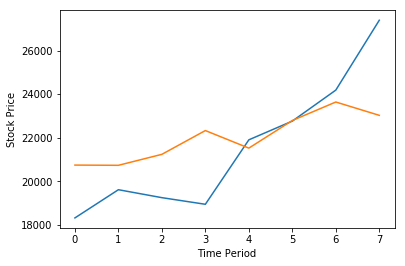

In [37]:
answer=LSTM(txs,8,'WeekNumber_Month_Season_Year' )

In [38]:
len(answer)

2

In [39]:
predict=answer[0]

In [40]:
real=answer[1]

In [41]:
predict

array([ 20745.7734375 ,  20735.5859375 ,  21239.3046875 ,  22330.1875    ,
        21524.2890625 ,  22791.62109375,  23639.71679688,  23028.32617188], dtype=float32)

In [42]:
real

array([ 18322.36999106,  19616.21999036,  19251.49999056,  18947.80999072,
        21904.46998912,  22764.00998865,  24185.26998787,  27390.80998609])

In [43]:
rmse(predict,real)

2291.0669659523501

In [ ]:
denormalizedTestPredictY=[item for sublist in predict for item in sublist]

In [ ]:
denormalizedTestPredictY

In [ ]:
denormalizedTestY=originalSales[train_size+seq_length:]

In [ ]:
# sales=noOutlierSales(sales)
tempxy=[list(txs['season']),list(txs['year']),list(txs['month']),list(txs['week_number']),sales]
# tempxy=[list(txs['season']),list(txs['day_of_week01']),list(txs['week_number']),sales]
xy=np.array(tempxy).transpose().astype(np.float)
originalxy=np.array(tempxy).transpose().astype(np.float)
xy=minMaxNormalizer(xy)

#data_dim은 y값 도출을 위한 feature 가지수+1(독립변수 가지수 +1(y포함))
data_dim=len(tempxy)
#data_dim크기의 data 한 묶음이 seq_length만큼 input으로 들어가
seq_length=5
#output_dim(=forecastDays)만큼의 다음날 y_data를 예측

output_dim=forecastDay
#hidden_dim은 정말 임의로 설정
hidden_dim=100
#learning rate은 배우는 속도(너무 크지도, 작지도 않게 설정)
learning_rate=0.01
#iterations는 반복 횟수
iterations=1000
x=xy
y=xy[:,[-1]]

#build a series dataset(seq_length에 해당하는 전날 X와 다음 forecastDays에 해당하는 Y)
dataX=[]
dataY=[]
for i in range(0, len(y)-seq_length - forecastDay):
    _x=x[i:i+seq_length]
    _y = y[i + seq_length:i + seq_length + forecastDay]
    _y = np.reshape(_y, (forecastDay))
#     print(_x,"->",_y)
    dataX.append(_x)
    dataY.append(_y)
    train_size = int(len(dataY) * 0.7)
    
test_size = len(dataY) - train_size
trainX, testX = np.array(dataX[0:train_size]), np.array(dataX[train_size:])
trainY, testY = np.array(dataY[0:train_size]), np.array(dataY[train_size:])
X=tf.placeholder(tf.float32, [None, seq_length, data_dim])
Y=tf.placeholder(tf.float32, [None, forecastDay])

cell = tf.contrib.rnn.BasicLSTMCell(num_units=hidden_dim, state_is_tuple=True, activation=tf.tanh)
outputs, _states = tf.nn.dynamic_rnn(cell, X, dtype=tf.float32)
Y_pred = tf.contrib.layers.fully_connected(outputs[:, -1], output_dim, activation_fn= None) 
loss = tf.reduce_sum(tf.square(Y_pred - Y))  # sum of the squares
optimizer = tf.train.AdamOptimizer(learning_rate)
train = optimizer.minimize(loss)
denormalizedTestY=originalSales[train_size+seq_length:]
# denormalizedTestY_original=sales[train_size+seq_length:]
denormalizedTestY_feed=np.array([[i] for i in denormalizedTestY])

targets = tf.placeholder(tf.float32, [None, 1])
predictions = tf.placeholder(tf.float32, [None, 1])
rmse = tf.sqrt(tf.reduce_mean(tf.square(targets - predictions)))
with tf.Session() as sess:
    #초기화
    init = tf.global_variables_initializer()
    sess.run(init)

    # Training step
    for i in range(iterations):
        _, step_loss = sess.run([train, loss], feed_dict={X: trainX, Y: trainY})
        print("[step: {}] loss: {}".format(i, step_loss))

    # Test step
    test_predict = minMaxDeNormalizer(sess.run(Y_pred, feed_dict={X: testX}),originalxy)

    # Plot predictions
    plt.plot(denormalizedTestY_feed) #실제 sales 파란색
    plt.plot(test_predict)           #예측 sales 주황색
    plt.xlabel("Time Period")
    plt.ylabel("Stock Price")
    plt.show()

In [ ]:
print(i for i in list(test_predict[-1]    ))

In [5]:
list(test_predict[  )

[17721.039]

In [6]:
denormalizedTestPredictY=[item for sublist in test_predict for item in sublist]

In [7]:
rootMeanSquaredError(denormalizedTestY,denormalizedTestPredictY)

IndexError: list index out of range

In [ ]:
len(denormalizedTestPredictY)

In [ ]:
denormalizedTestY